In [ ]:
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.constraints import MinMaxNorm, MaxNorm
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping

from scipy.stats.stats import pearsonr

from google.colab import drive
drive.mount('/content/gdrive')

<ipython-input-1-9c7940b3ce8d>:21: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


Mounted at /content/gdrive


In [ ]:
# df8 = pd.read_csv("8dec.csv")
# df17 = pd.read_csv("17dec.csv")
# df817 = pd.read_csv("8dec17dec.csv")
# df321 = pd.read_csv("3dec21dec.csv")
from google.colab import files
uploaded = files.upload()

dfrabitrain= pd.read_csv("Rabi_train - Sheet1.csv")
dfrabitest= pd.read_csv("Rabi_test - Sheet1.csv")
df817 = pd.read_csv("8dec17dec - Sheet1.csv")
df321 = pd.read_csv("3dec21dec - Sheet1.csv")

from pathlib import Path
image_dir= Path("/content/gdrive/MyDrive/AYUSHH/Xtest8dec17dec")
# image_dir= Path("Xtest8dec17dec")
filepaths_1 = pd.Series(list(image_dir.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_1 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_1]
sorted_filepaths_1 = [x for _, x in sorted(zip(numeric_parts_1, filepaths_1))]
filepaths_series_1 = pd.Series(sorted_filepaths_1, name='Filepath')
bmass_1 = df817['Biomass']
images_1 =  pd.concat([filepaths_series_1,bmass_1],axis=1)

image_dir_4= Path("/content/gdrive/MyDrive/AYUSHH/Rabi22_23_Test")
filepaths_4 = pd.Series(list(image_dir_4.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_4 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_4]
sorted_filepaths_4 = [x for _, x in sorted(zip(numeric_parts_4, filepaths_4))]
filepaths_series_4 = pd.Series(sorted_filepaths_4, name='Filepath')
bmass_4 = dfrabitest['Biomass']
images_4 = pd.concat([filepaths_series_4,bmass_4],axis=1)

test_images = pd.concat([images_1, images_4], ignore_index=True)


image_dir_3= Path("/content/gdrive/MyDrive/AYUSHH/Xtrain3dec21dec")
# image_dir_3= Path("Xtrain3dec21dec")
filepaths_3 = pd.Series(list(image_dir_3.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_3 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_3]
sorted_filepaths_3 = [x for _, x in sorted(zip(numeric_parts_3, filepaths_3))]
filepaths_series_3 = pd.Series(sorted_filepaths_3, name='Filepath')
bmass_3 = df321['Biomass']
images_3 = pd.concat([filepaths_series_3,bmass_3],axis=1)

image_dir_2= Path("/content/gdrive/MyDrive/AYUSHH/rabi_22_23data")
filepaths_2 = pd.Series(list(image_dir_2.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_2 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_2]
sorted_filepaths_2 = [x for _, x in sorted(zip(numeric_parts_2, filepaths_2))]
filepaths_series_2 = pd.Series(sorted_filepaths_2, name='Filepath')
bmass_2 = dfrabitrain['Biomass']
images_2 = pd.concat([filepaths_series_2,bmass_2],axis=1)

train_images = pd.concat([images_2, images_3], ignore_index=True)

Saving 3dec21dec - Sheet1.csv to 3dec21dec - Sheet1.csv
Saving 8dec17dec - Sheet1.csv to 8dec17dec - Sheet1.csv
Saving Rabi_test - Sheet1.csv to Rabi_test - Sheet1.csv
Saving Rabi_train - Sheet1.csv to Rabi_train - Sheet1.csv


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_images['Biomass'] = scaler.fit_transform(train_images['Biomass'].values.reshape(-1, 1))  # leanrt u and sigma for train data

train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator( # data_gen object -- in parameters ke according iamge par operation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_data = train_generator_aug.flow_from_dataframe(      #6D --- (5D,2D) tensor ( #batches and other 4)
    dataframe=train_images,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512), # why use this?
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,   # small batch size -- noisier gradient descent
    shuffle=True,
    seed=42,
    subset='training'
)
# X_train, y_train = next(train_data)   # batch data
# X_train2,y_train2= train_images       # too much data to unpack

val_data = train_generator_aug.flow_from_dataframe(
    dataframe=train_images,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)
# X_val, y_val = next(val_images)

test_data = test_generator_aug.flow_from_dataframe(
    dataframe=test_images,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=2,
    shuffle=False
)
# X_test, y_test = next(test_images)
# X_test shape is 2,512,512,3
# y_test shape is (2,)

Found 231 validated image filenames.
Found 57 validated image filenames.
Found 180 validated image filenames.


In [ ]:
import tensorflow as tf
from keras.applications import MobileNetV2

# Load MobileNetV2 model without top (fully connected layers)
base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

# Print model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                             

Epoch 1/75
58/58 [==============================] - 46s 795ms/step - loss: 0.6439 - mae: 0.6313 - root_mean_squared_error: 0.8024 - val_loss: 0.2152 - val_mae: 0.4412 - val_root_mean_squared_error: 0.4639
Epoch 2/75
58/58 [==============================] - 42s 731ms/step - loss: 0.3194 - mae: 0.4299 - root_mean_squared_error: 0.5651 - val_loss: 0.3377 - val_mae: 0.5621 - val_root_mean_squared_error: 0.5811
Epoch 3/75
58/58 [==============================] - 51s 878ms/step - loss: 0.3578 - mae: 0.4613 - root_mean_squared_error: 0.5981 - val_loss: 0.0622 - val_mae: 0.2312 - val_root_mean_squared_error: 0.2494
Epoch 4/75
58/58 [==============================] - 41s 708ms/step - loss: 0.3148 - mae: 0.4051 - root_mean_squared_error: 0.5611 - val_loss: 0.1636 - val_mae: 0.3842 - val_root_mean_squared_error: 0.4044
Epoch 5/75
58/58 [==============================] - 41s 717ms/step - loss: 0.3155 - mae: 0.4230 - root_mean_squared_error: 0.5617 - val_loss: 0.1954 - val_mae: 0.4176 - val_root_me

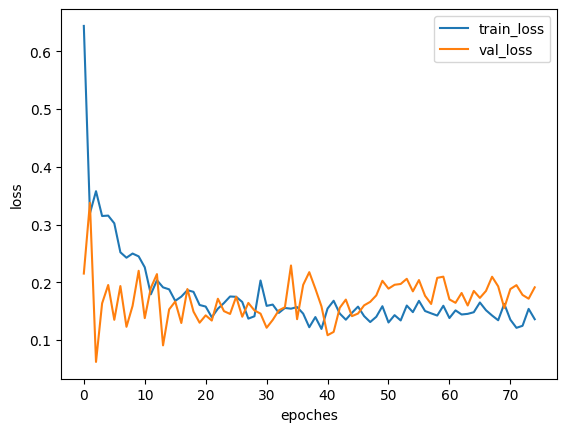

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=75,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
ccvxccn

In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/__New_Work__/mobilerobust.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


90/90 [==============================] - 78s 863ms/step
Test dataset prediction - 8dec
euqation of line is : y=[0.35514709]*x + [366.64778817]
r2 score= 0.531
mae=227.977
mse=69,541.043
rmse=263.706


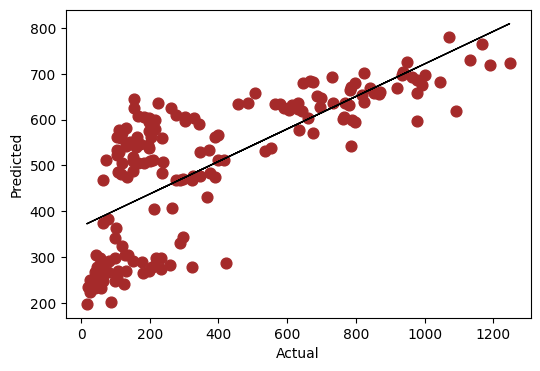

In [ ]:
Pred= model.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = test_images['Biomass'].values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - 8dec")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))